In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import itertools as it
import collections as C
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import optim
from dataclasses import dataclass, field
torch.set_printoptions(linewidth=150)

In [2]:
import functools as ft
from tqdm.notebook import tqdm

### Data exploration

In [3]:
words = open("names.txt").read().splitlines()
words[:2]

['emma', 'olivia']

In [4]:
SPL = '.'

In [5]:
min(map(len, words)), max(map(len, words))

(2, 15)

In [6]:
len(words)

32033

### Bigram model

In [7]:
chars = [SPL] + sorted(set(it.chain.from_iterable(words)))
nchars = len(chars)
ctoix = {c:i for i, c in enumerate(chars)}
ixtoc = dict(enumerate(chars))
ctoix

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [8]:
bigrams = torch.zeros((nchars,nchars))
for w in words:
    ch = [SPL] + list(w) + [SPL]
    for c1, c2 in zip(ch, ch[1:]):
        bigrams[ctoix[c1], ctoix[c2]] += 1

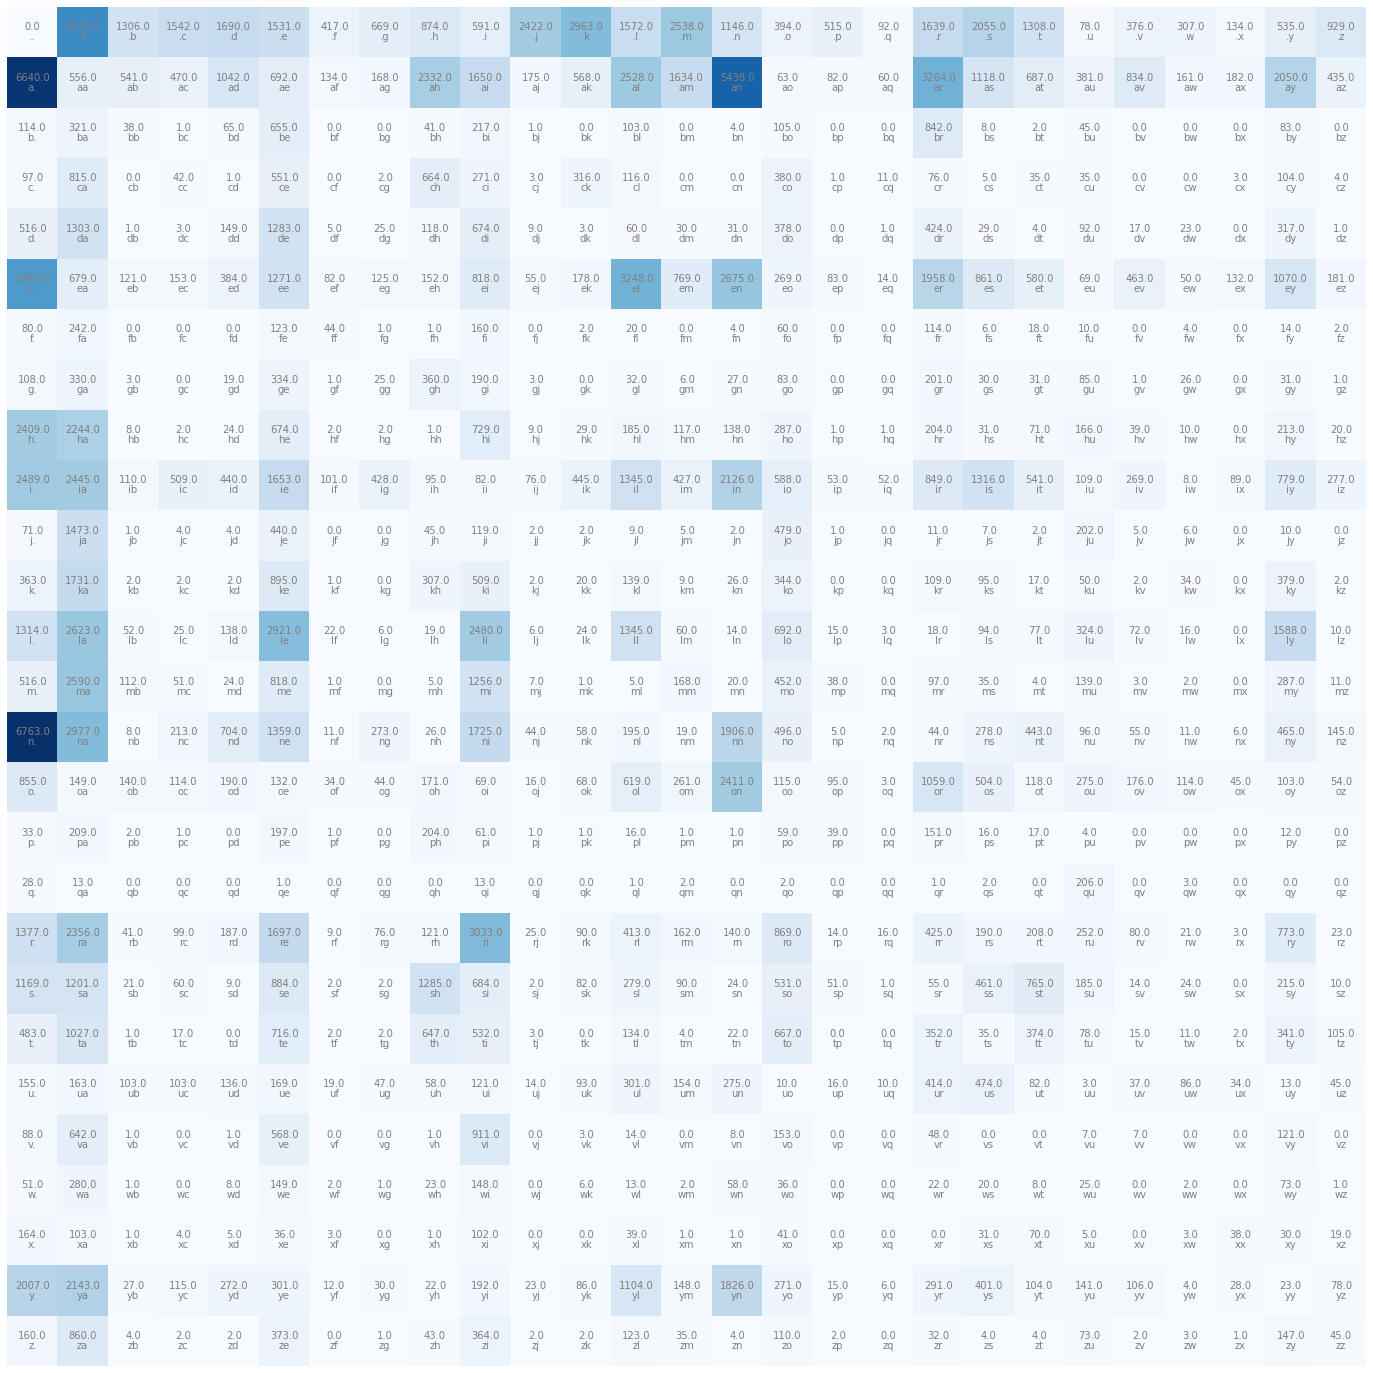

In [9]:
plt.figure(figsize=(25,25))
plt.imshow(bigrams, cmap='Blues')
for i, j in it.product(range(nchars), range(nchars)):
    plt.text(j, i, ixtoc[i]+ixtoc[j], ha='center', va='top', color='gray')
    plt.text(j, i, bigrams[i,j].item(), ha='center', va='bottom', color='gray')
_=plt.axis(False)

In [10]:
def generate_word(P, g=None):
    g = g if g else torch.Generator().manual_seed(2147483647)
    row_ix, c, w = 0, '.', []
    while True:
        row_ix = torch.multinomial(P[row_ix], num_samples=1, replacement=True, generator=g).item()
        c = ixtoc[row_ix]
        if c == '.':
            break
        w.append(c)
    return ''.join(w)

def nll_bigram(words, P, ctoix):
    nll = torch.tensor([0.])
    n = 0
    for w in words:
        w = [SPL] + list(w) + [SPL]
        for c1, c2 in  zip(w, w[1:]):
            nll -= torch.log(P[ctoix[c1], ctoix[c2]])
            n += 1
    return {"word": nll/len(words), "bigram": nll/n}

In [11]:
smth_bigrams = bigrams + 1.
P = bigrams / bigrams.sum(dim=1, keepdim=True)
Psmth = smth_bigrams / smth_bigrams.sum(dim=1, keepdim=True)
g = torch.Generator().manual_seed(2147483647)
for _ in range(20):
    print(generate_word(P , g))

mor
axx
minaymoryles
kondlaisah
anchshizarie
odaren
iaddash
h
jhinatien
egushl
h
br
a
jayn
ilemannariaenien
be
f
akiinela
trttanakeroruceyaaxatona
lamoynayrkiedengin


In [12]:
nll_bigram(words=words, P=P, ctoix=ctoix)

{'word': tensor([17.4786]), 'bigram': tensor([2.4541])}

In [13]:
nll_bigram(words=["vishnu"], P=P, ctoix=ctoix)

{'word': tensor([22.1936]), 'bigram': tensor([3.1705])}

In [14]:
nll_bigram(words=["vishnuqj"], P=P, ctoix=ctoix)

{'word': tensor([inf]), 'bigram': tensor([inf])}

In [15]:
nll_bigram(words=["vishnuqj"], P=Psmth, ctoix=ctoix)

{'word': tensor([34.2515]), 'bigram': tensor([3.8057])}

### MLP

#### Create dataset of bigrams

In [16]:
nwords = len(words)
xs = []
ys = []
for i, w in enumerate(words):
    w = [SPL] + list(w) + [SPL]
    for c1, c2 in zip(w, w[1:]):
        xs.append(ctoix[c1])
        ys.append(ctoix[c2])
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [17]:
xs

tensor([ 0,  5, 13,  ..., 25, 26, 24])

In [18]:
xenc = F.one_hot(xs, num_classes=nchars).float()
yenc = F.one_hot(ys, num_classes=nchars).float()

In [20]:
def nll(y_pred, y_true):
    y_true, y_pred = yenc[:batch_size], model(xenc[:batch_size])
    # softmax
    y_exp_pred = torch.exp(y_pred)
    y_pred_prob = y_exp_pred/y_exp_pred.sum(axis=1, keepdim=True)
    # nll by only choosing output
    return -torch.log((y_pred_prob*y_true).sum(axis=1)).mean()

In [22]:
xt, yt = xenc, yenc
W = torch.randn((27, 27), requires_grad=True)

In [61]:
num_data = xt.shape[0]
row_ixes = torch.arange(num_data)
for _ in (pbar := tqdm(range(300))):
    yp = F.softmax(xt @ W, dim=1)
    loss = -yp[row_ixes, ys].log().mean() + 0.001*(W**2).mean()
    W.grad = None
    loss.backward()
    W.data -=  W.grad * 15
    W.requires_grad = True
    pbar.set_description(f"loss={loss.item()} W.norm={torch.norm(W).item()}")

  0%|          | 0/300 [00:00<?, ?it/s]

In [39]:
ctoix['e']

5

In [53]:
F.softmax(W[5], dim=0)

tensor([0.1950, 0.0332, 0.0059, 0.0075, 0.0188, 0.0622, 0.0040, 0.0061, 0.0074, 0.0401, 0.0027, 0.0087, 0.1590, 0.0377, 0.1310, 0.0132, 0.0041,
        0.0007, 0.0959, 0.0422, 0.0284, 0.0034, 0.0227, 0.0024, 0.0065, 0.0524, 0.0089], grad_fn=<SoftmaxBackward0>)

In [42]:
P[5]

tensor([0.1950, 0.0332, 0.0059, 0.0075, 0.0188, 0.0622, 0.0040, 0.0061, 0.0074, 0.0401, 0.0027, 0.0087, 0.1590, 0.0377, 0.1310, 0.0132, 0.0041,
        0.0007, 0.0959, 0.0422, 0.0284, 0.0034, 0.0227, 0.0024, 0.0065, 0.0524, 0.0089])

In [57]:
(W**2).sum()

tensor(2284.6902, grad_fn=<SumBackward0>)

In [62]:
for i in range(5):
    print(f"char: {ixtoc[i]}", f"{(P-F.softmax(W, dim=0)).mean():.4f}")

char: . 0.0000
char: a 0.0000
char: b 0.0000
char: c 0.0000
char: d 0.0000


In [64]:
g = torch.Generator().manual_seed(2147483647)
for _ in range(20):
    print(generate_word(F.softmax(W, dim=1) , g))

mor
axx
minaymoryles
kondlaisah
anchshizarie
odaren
iaddash
h
jionatien
egwulo
ga
t
a
jayn
ilemannariaenien
ad
f
akiinela
trttanakeroruceyaaxatona
lamoyonutonadengin
